In [1]:
import sys
sys.path.append('.conda/envs/shear/lib/python3.9/site-packages/')

import numpy as np
import astropy.io.fits as pf
import pylab as mplot
import yaml
import h5py
import healpy as hp
import healsparse as hs
import scipy
from scipy import interpolate

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Instructions

This notebook tries to make mean shear vs. SP map plots, fits a line and returns the slope and intercept

We need these maps

From shear cat
* T ratio 
* s/n
* (PSF e1)
* (PSF e2)

From Peter’s maps
* Depth i
* Brightness i
* Exp time i
* Airmass i
* Seeing i


In [2]:
tag = '0613'
project_dir = '/project/chihway/data/decade/'

## Make shear maps

In [3]:
# pixelate shear into 4096 maps, use v2 weights

In [4]:
# first get mask total

with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:]
    sg = h5r['sg_bdf'][:] 
    fg = h5r['FLAGS_FOREGROUND'][:] 
    T = h5r['mcal_T_noshear'][:]
    mcal_flags = h5r['mcal_flags'][:]
    g1, g2  = h5r['mcal_g_noshear'][:].T
    flux_r, flux_i, flux_z = h5r['mcal_flux_noshear'][:].T

mag_r = -2.5*np.log10(flux_r)+30
mag_i = -2.5*np.log10(flux_i)+30
mag_z = -2.5*np.log10(flux_z)+30

# PZ mask
mcal_pz_mask = ((mag_i < 23.5) & (mag_i > 18) & 
                    (mag_r < 26)   & (mag_r > 15) & 
                    (mag_z < 26)   & (mag_z > 15) & 
                    (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) & 
                    (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))

# Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
SNR_Mask   = (s2n > 10) & (s2n < 1000)
Tratio_Mask= size_ratio > 0.5
T_Mask = T < 10
Flag_Mask = (mcal_flags == 0)
Other_Mask = np.invert((T > 2) & (s2n < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))
SG_Mask = (sg>=4)
FG_Mask = (fg==0)

mask_total = mcal_pz_mask & SNR_Mask & Tratio_Mask & T_Mask & Flag_Mask & Other_Mask & SG_Mask & FG_Mask

del size_ratio, s2n, sg, fg, T, mcal_flags, g1, g2, flux_r, flux_i, flux_z, mag_r, mag_i, mag_z
del mcal_pz_mask, SNR_Mask, Tratio_Mask, T_Mask, Flag_Mask, Other_Mask, SG_Mask

/scratch/local/jobs/6486989/ipykernel_2812670/2547016843.py:13: RuntimeWarning: invalid value encountered in log10
  mag_r = -2.5*np.log10(flux_r)+30
/scratch/local/jobs/6486989/ipykernel_2812670/2547016843.py:14: RuntimeWarning: invalid value encountered in log10
  mag_i = -2.5*np.log10(flux_i)+30
/scratch/local/jobs/6486989/ipykernel_2812670/2547016843.py:15: RuntimeWarning: invalid value encountered in log10
  mag_z = -2.5*np.log10(flux_z)+30
/scratch/local/jobs/6486989/ipykernel_2812670/2547016843.py:29: RuntimeWarning: invalid value encountered in log10
  Other_Mask = np.invert((T > 2) & (s2n < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))


In [7]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    ra = h5r['RA'][:] #[mask_total]
    dec = h5r['DEC'][:] #[mask_total]
    g1, g2  = h5r['mcal_g_noshear'][:].T #[:][mask_total].T
    w2 =  h5r['mcal_g_w_v2'][:] #[mask_total] # we will use v2 weights

In [8]:
ra = ra[mask_total]
dec = dec[mask_total]
w2 = w2[mask_total]
g1 = g1[mask_total]
g2 = g2[mask_total]


In [9]:
# copiped from neff notebook
R11 = 0.7443824304923087 
R11s = 0.047189013967600654
R22 = 0.7455737932558067 
R22s = 0.04767254335307269
R11tot = 0.7915714444599093 
R22tot = 0.7932463366088794

In [11]:
nside = 4096
map_counts = np.zeros(hp.nside2npix(nside))
map_weight = np.zeros(hp.nside2npix(nside))
map_gal_e1 = np.zeros(hp.nside2npix(nside))
map_gal_e2 = np.zeros(hp.nside2npix(nside))

phi = ra/180*np.pi
theta = (90.-dec)/180*np.pi

pix = hp.ang2pix(nside, theta, phi)

In [13]:
for i in range(len(pix)):
    map_counts[pix[i]] += 1
    map_weight[pix[i]] += w2[i]
    map_gal_e1[pix[i]] += (g1[i]/R11tot)*w2[i]
    map_gal_e2[pix[i]] += (g2[i]/R22tot)*w2[i]

In [14]:
def divide_map(map1, map2):
    outmap = map1.copy()
    outmap[map2>0] /= map2[map2>0]
    outmap[map2==0] = hp.UNSEEN
    return outmap

In [16]:
# save g1, g2, counts, weights maps
map_dir = '/project/chihway/data/decade/SP_maps/mcal/'
hp.write_map(map_dir+'ncounts_2023'+tag+'.fits', map_counts, overwrite=True)
hp.write_map(map_dir+'g1_2023'+tag+'.fits', divide_map(map_gal_e1,map_weight), overwrite=True)
hp.write_map(map_dir+'g2_2023'+tag+'.fits', divide_map(map_gal_e2,map_weight), overwrite=True)
hp.write_map(map_dir+'weights_2023'+tag+'.fits', map_weight, overwrite=True)


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


## Get all the maps, apply the same mask, plot in nside 4096

delve_dr3_1_1_r_airmass_wmean.hs


<Figure size 640x480 with 0 Axes>

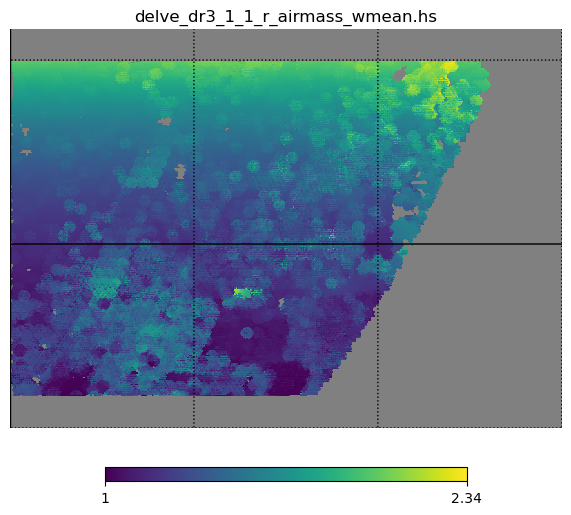

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_g_airmass_wmean.hs


<Figure size 640x480 with 0 Axes>

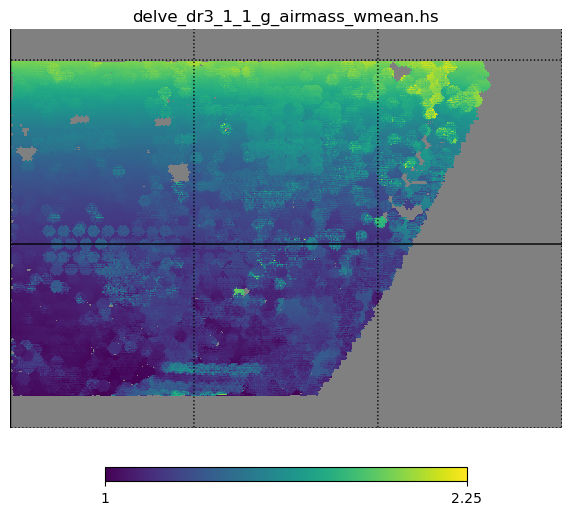

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_i_airmass_wmean.hs


<Figure size 640x480 with 0 Axes>

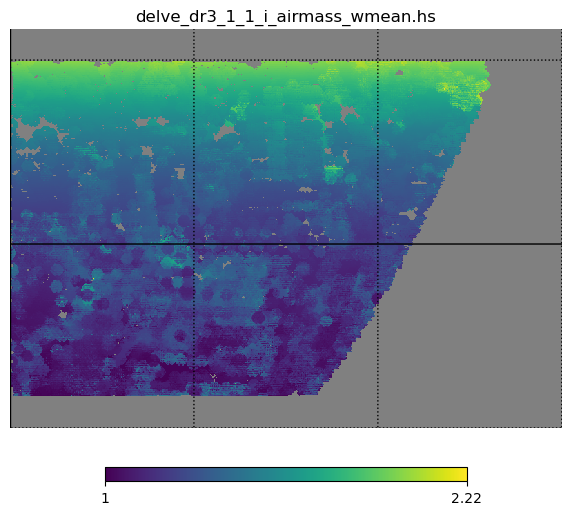

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_z_airmass_wmean.hs


<Figure size 640x480 with 0 Axes>

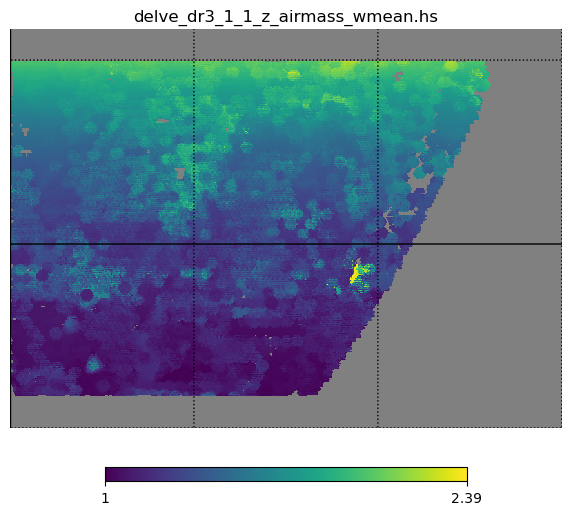

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_z_dcr_ddec_wmean.hs


<Figure size 640x480 with 0 Axes>

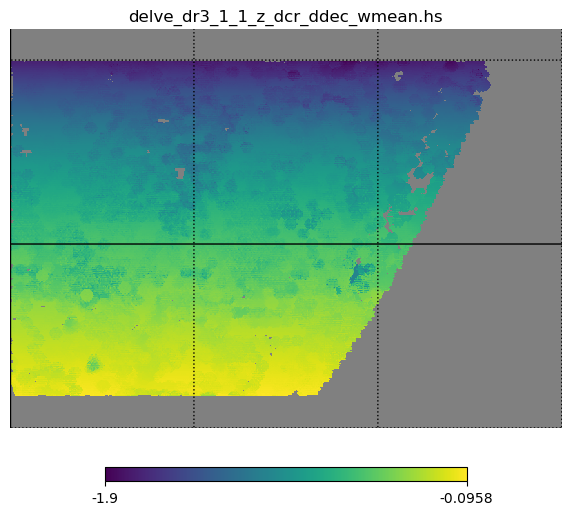

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_g_dcr_e1_wmean.hs


<Figure size 640x480 with 0 Axes>

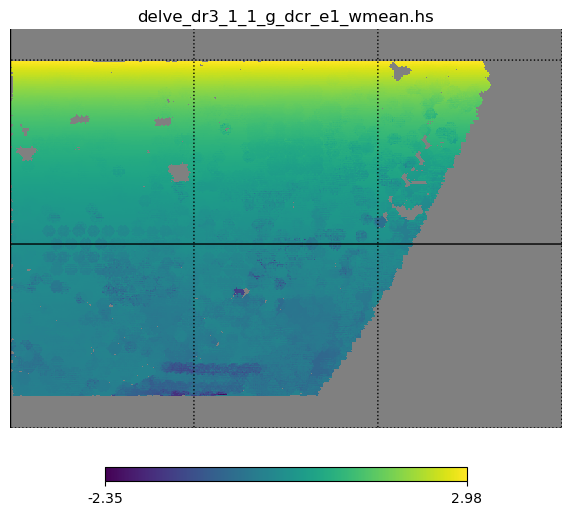

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_i_dcr_e2_wmean.hs


<Figure size 640x480 with 0 Axes>

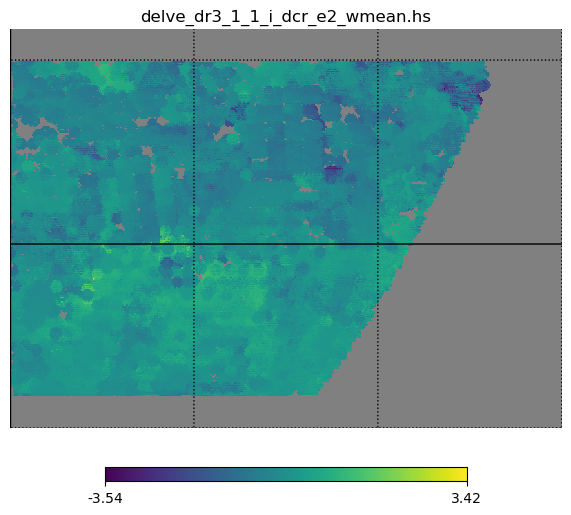

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_z_dcr_e1_wmean.hs


<Figure size 640x480 with 0 Axes>

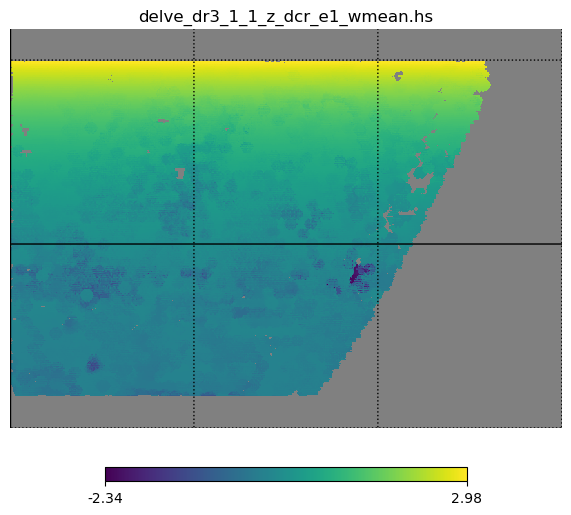

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_i_dcr_dra_wmean.hs


<Figure size 640x480 with 0 Axes>

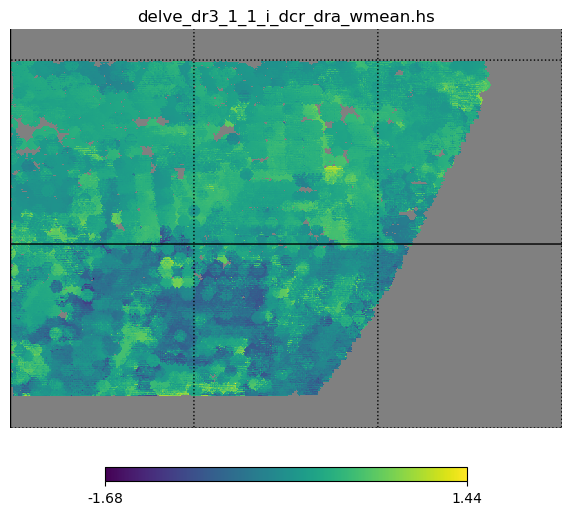

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_i_dcr_e1_wmean.hs


<Figure size 640x480 with 0 Axes>

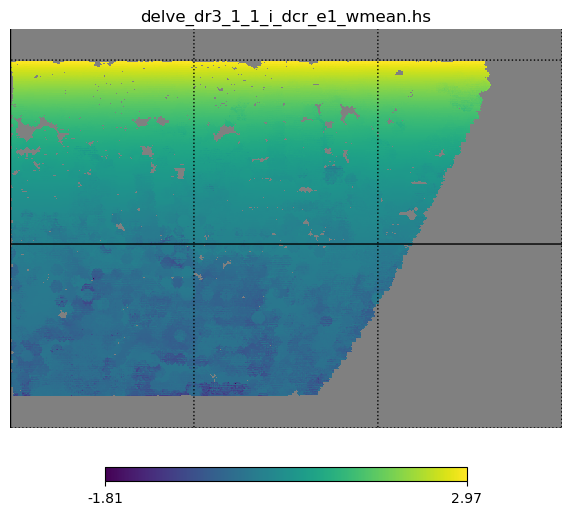

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_g_dcr_dra_wmean.hs


<Figure size 640x480 with 0 Axes>

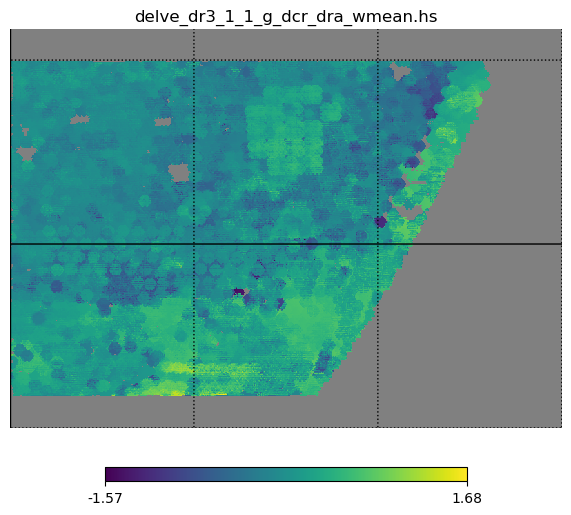

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_r_dcr_ddec_wmean.hs


<Figure size 640x480 with 0 Axes>

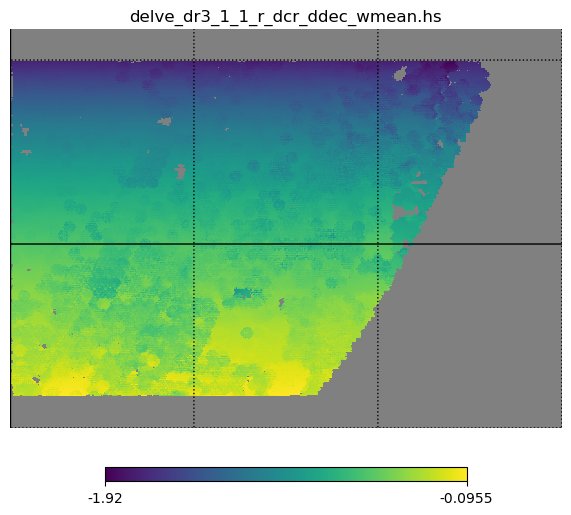

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_i_dcr_ddec_wmean.hs


<Figure size 640x480 with 0 Axes>

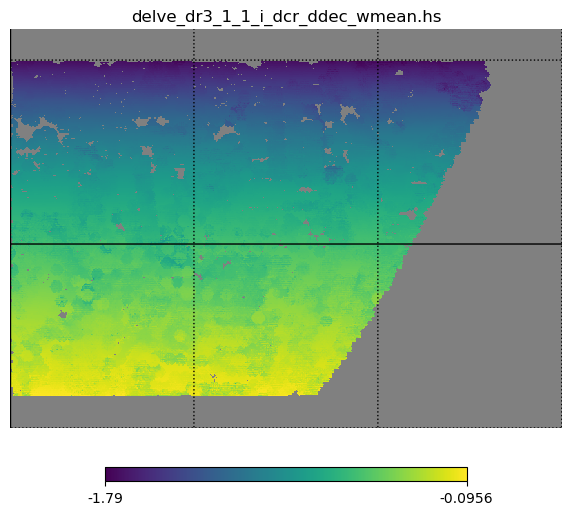

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_r_dcr_dra_wmean.hs


<Figure size 640x480 with 0 Axes>

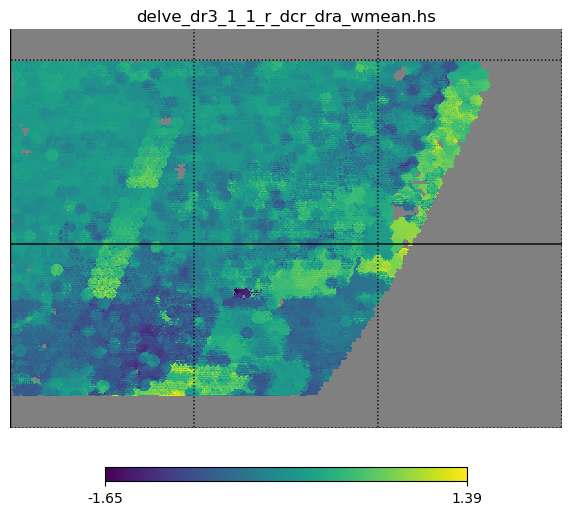

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_g_dcr_ddec_wmean.hs


<Figure size 640x480 with 0 Axes>

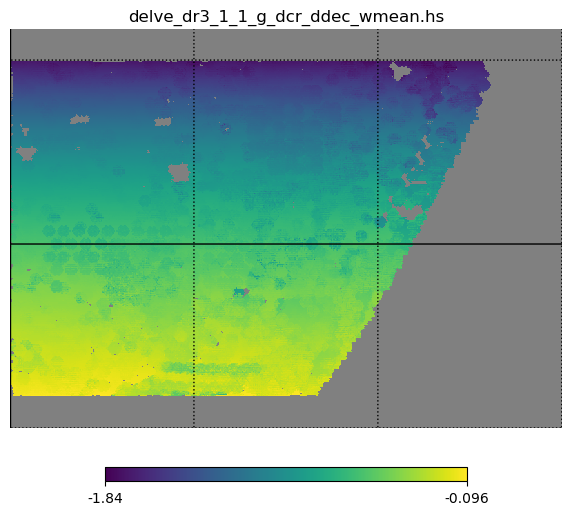

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_z_dcr_e2_wmean.hs


<Figure size 640x480 with 0 Axes>

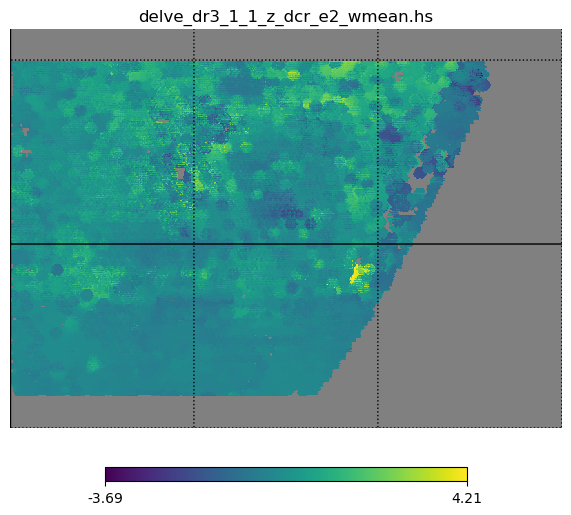

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_g_dcr_e2_wmean.hs


<Figure size 640x480 with 0 Axes>

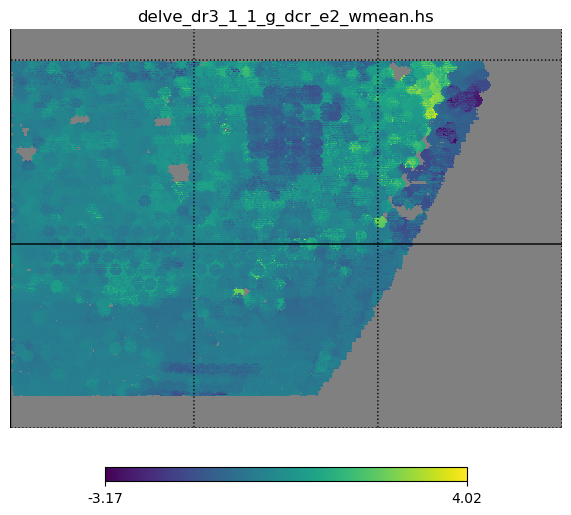

setting the output map dtype to [dtype('float64')]


delve_dr3_1_1_z_dcr_dra_wmean.hs


<Figure size 640x480 with 0 Axes>

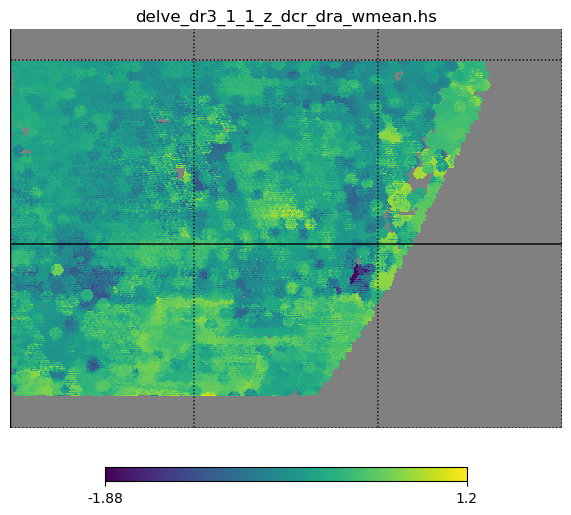

setting the output map dtype to [dtype('float64')]


In [ ]:
Types = ['airmass', 'dcr', 'exptime', 'fwhm', 'maglim', 'nexp', 'skybrite', 'skysigma']

#coverage
import os
for SP in Types:
    file_list = os.listdir('/project/chihway/data/decade/SP_maps/'+SP)   
    for file_name in file_list:
        print(file_name)
        hsp_map = hs.HealSparseMap.read('/project/chihway/data/decade/SP_maps/'+SP+'/'+file_name)
        X = hsp_map.generate_healpix_map(nside=4096)
        mplot.figure()
        hp.cartview(X, nest=True, lonra=[90,180], latra=[-30,35], title=file_name)
        hp.graticule()
#         hp.mollview(X, nest=True, Title=filename)
        mplot.show()
        hp.write_map('/project/chihway/data/decade/SP_maps/'+SP+'/'+file_name[:-3]+'.fits', X, overwrite=True)

    

In [ ]:
# do correlation, fit line, store plots